In [1]:
import pandas as pd
import os
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import sys
import morphsnakes as ms
from skimage import morphology
from skimage.measure import label
from skimage.segmentation import active_contour
from skimage import data, io, img_as_ubyte,filters
import matplotlib as mpl

import imutils #image processing - when finding top/bottom/left/right points
from PIL import ImageEnhance #add this to first cell
from PIL import Image


import math 
%matplotlib inline
mpl.rc('image', interpolation='none')
plt.rcParams['figure.figsize'] = (7.0, 7.0)

from astropy.table import QTable #for calculation tables
from tabulate import tabulate #for calculation tables


In [2]:
def show(im):
    plt.imshow(im,"bone")
    plt.show()

In [3]:
path="C:/Users/Dr. Wong's Lab/Downloads/Jason_Thigh/"

In [4]:
def import_im(im_filename):
    sitk_im=sitk.ReadImage(os.path.join(path,im_filename))
    arr_im=sitk.GetArrayFromImage(sitk_im[:, :]) 
    return arr_im

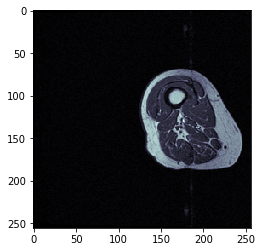

In [5]:
thigh=import_im("thigh_IHc.nrrd")
show(thigh)

In [6]:
def multi_otsu(image): #only difference from multi_otsu_slice is title (includes slice # here)
    motsuth=filters.threshold_multiotsu(image, classes=3)
    #print(motsuth)
    #print (f"Slice {i+1} otsu threshold={motsuth[1]}")
    
    regions=np.digitize(image,bins=motsuth)
    output=img_as_ubyte(regions)
    return motsuth[1] #(fat+ muscle th)

def IH_correction_subcfat(image,mask): #not sure id need forloop
    inputImage=sitk.GetImageFromArray(image)
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32 )
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output = corrector.Execute( inputImage, mask)
    image_c= sitk.GetArrayFromImage(output)
    image_c=cv2.normalize(src=image_c, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) #need to normalize, not direct conversion by "np.uint8"
    return image_c


def IH_mask(image): #function to get mask to be used in IH correction
    IH_th=multi_otsu(image) #apply multiotsu to get subcutaneous fat threshold
    IH_mask=label(image>IH_th)
    #IH_mask= (morphology.remove_small_objects(IH_mask,min_size=1000, connectivity=1)) #should we remove holes too or nah??
    IH_mask = (morphology.remove_small_holes(IH_mask,area_threshold=16, connectivity=1)).astype(int) #added jan7
    IH_mask= cv2.normalize(src=IH_mask, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    ret, IH_mask = cv2.threshold(IH_mask,0,1,cv2.THRESH_BINARY)
    IH_mask = cv2.morphologyEx(IH_mask, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8)) #added jan7
    #   plt.imshow(IH_mask)
    IH_mask=sitk.GetImageFromArray(IH_mask) #convert to sitk image
    return IH_mask





### IHc#1

D:\Anaconda\lib\site-packages\skimage\util\dtype.py:525: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


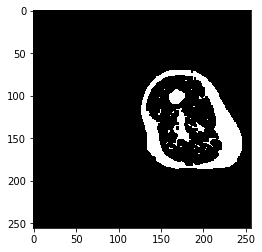

In [7]:
#get mask 
#-from uncorrected image Ivol8
IH1vol_mask=IH_mask(thigh)


# convert from image to array to view masks
show_IH1vol_mask=sitk.GetArrayFromImage(IH1vol_mask) 
show(show_IH1vol_mask)

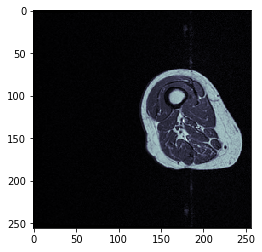

In [8]:
#apply IH using mask
thigh_c=IH_correction_subcfat(thigh,IH1vol_mask)
show(thigh_c)

## Get contours of outline



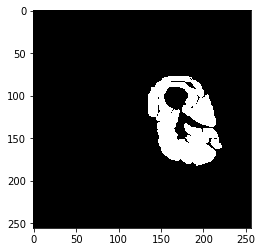

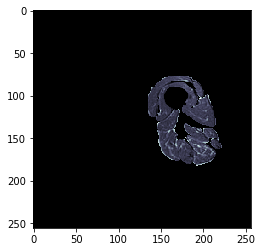

In [9]:
thighseg_mask=import_im("thigh_mask.nrrd")

thighseg_mask=thighseg_mask.astype(np.uint8)
show(thighseg_mask)

thighseg=(thighseg_mask*thigh_c).astype(np.uint8)
show(thighseg)

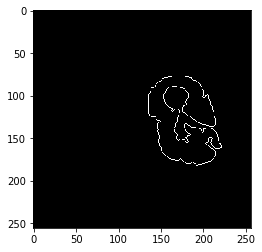

In [10]:
##Get contours 
def get_contour(image):
    
    outline=[]
    contours, hierc =  cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    zeros=np.zeros([image.shape[0], image.shape[1]], dtype='uint8') 
    outline=cv2.drawContours(zeros, contours,  0, (1,0,0), 0)
    #plt.imshow(outline,"bone")
    #plt.show()
    return contours,outline, hierc

thigh_contour_coords,thigh_contour_im, hierc=get_contour(thighseg_mask)
show(thigh_contour_im)


#find contour of thigh segmentation 
#get the hull for it - connect the lines?
#may need to alter floodfill fxn
#last resort - use find muscle mask method in OG code


In [11]:
hull_coords=[]
for i in range(len(thigh_contour_coords)):
    hull_coords.append(cv2.convexHull(thigh_contour_coords[i], True))


In [13]:

# create an empty black image

hull_im = np.zeros((thigh.shape[0], thigh.shape[1], 3), np.uint8)

# draw contours and hull points

for i in range(len(thigh_contour_coords)):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull

    # draw ith contour
#     cv2.drawContours(drawing, contour_coords, i, color_contours, 1, 8,hierch)

    # draw ith convex hull object

    cv2.drawContours(hull_im, hull_coords, i, color, 1, 8)


uint8


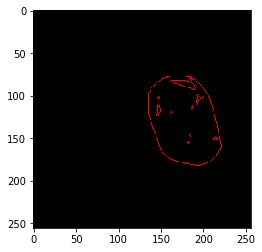

In [14]:
print(hull_im.dtype)
show(hull_im)


## Method 1

Slice area =6854.5
Slice area: 6854.5 AFTER
Slice area =2.0
Slice area =15.5
Slice area =2.0
Slice area =4.0
Slice area =2.0
Slice area =5.5
Slice area =25.0
Slice area =2.0
Slice area =4.0
Slice area =2.0
Slice area =4.0
Slice area =12.0
Slice area =2.0
Slice area =158.0
Slice area =2.0
Slice area =2.0


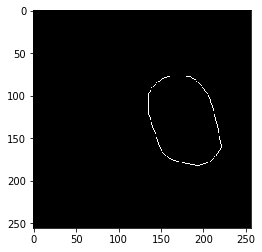

In [17]:
# remove small obj in drawing - if doesn't work then get new contour of hull


contours_keep=[]

for contour in hull_coords:
#     print(contour)
#     approx = cv2.arcLength(contour,True) #perimeter
    area = cv2.contourArea(contour) 
#             (x,y),radius = cv2.minEnclosingCircle(contour) #why need this here??
#             radius = int(radius)


    print(f"Slice area ={area}") 
    if  area>2000 :  
        contours_keep.append(contour)
        print(f"Slice area: {area} AFTER") 

    drawing2=np.zeros((thigh.shape[0], thigh.shape[1]), np.uint8)
    hull_im2 = cv2.drawContours(drawing2, contours_keep,  -1, (1,0,0), 1) #max=1 
    
show(hull_im2)

hull_contours_keep=contours_keep

In [18]:
def get_hull(contours): #reformat hull contour coordinates for snake
    hull2vol=[]
    
    for i2 in range(len(contours[0])): #changed here
        hull2vol.append(contours[0][i2][0]) #change here

    hull2vol=np.array(hull2vol) #needs to be OUTSIDE of for loop
    hull2vol=hull2vol.astype(float)
    return hull2vol
hull_contour_coords2=get_hull(hull_contours_keep)

print(hull_contours_keep)
print(hull_contour_coords2)

[array([[[177,  77]],

       [[182,  78]],

       [[186,  79]],

       [[191,  82]],

       [[196,  87]],

       [[206, 100]],

       [[210, 113]],

       [[214, 127]],

       [[221, 159]],

       [[221, 161]],

       [[214, 171]],

       [[208, 177]],

       [[204, 179]],

       [[201, 180]],

       [[193, 182]],

       [[192, 182]],

       [[180, 180]],

       [[162, 175]],

       [[158, 173]],

       [[151, 166]],

       [[150, 164]],

       [[148, 159]],

       [[135, 121]],

       [[135,  99]],

       [[138,  92]],

       [[146,  84]],

       [[152,  80]],

       [[154,  79]],

       [[158,  78]],

       [[163,  77]]], dtype=int32)]
[[177.  77.]
 [182.  78.]
 [186.  79.]
 [191.  82.]
 [196.  87.]
 [206. 100.]
 [210. 113.]
 [214. 127.]
 [221. 159.]
 [221. 161.]
 [214. 171.]
 [208. 177.]
 [204. 179.]
 [201. 180.]
 [193. 182.]
 [192. 182.]
 [180. 180.]
 [162. 175.]
 [158. 173.]
 [151. 166.]
 [150. 164.]
 [148. 159.]
 [135. 121.]
 [135.  99.]
 [138.  92.]


## Method 2

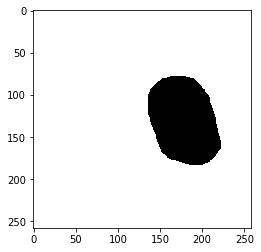

1
0


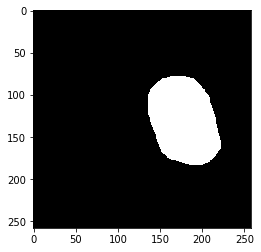

In [19]:
#floodfill hull outline

image=hull_im
im_floodfill = image.copy()
h, w = im_floodfill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill, mask, (0,0), 255);

show(mask)
th, im_floodfill_inv = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY_INV)


print(np.amax(im_floodfill_inv))
print(np.amin(im_floodfill_inv))

hull_mask=im_floodfill_inv
show(hull_mask)

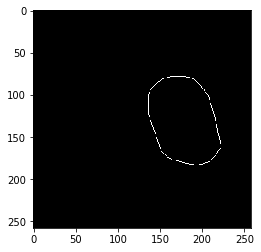

In [22]:
hull_contour_coords,hull_contour_im, hierc=get_contour(hull_mask)
show(hull_contour_im)

In [26]:
def get_hull(contours): #reformat hull contour coordinates for snake
    hull2vol=[]
    
    for i2 in range(len(contours[0])): #changed here
        hull2vol.append(contours[0][i2][0]) #change here

    hull2vol=np.array(hull2vol) #needs to be OUTSIDE of for loop
    hull2vol=hull2vol.astype(float)
    return hull2vol
hull_contour_coords2=get_hull(hull_contour_coords)
print(hull_contour_coords2)

[[162.  78.]
 [161.  79.]
 [160.  79.]
 [159.  79.]
 [158.  79.]
 [157.  80.]
 [156.  80.]
 [155.  80.]
 [154.  81.]
 [153.  81.]
 [152.  82.]
 [151.  82.]
 [150.  83.]
 [149.  84.]
 [148.  84.]
 [147.  85.]
 [146.  86.]
 [145.  87.]
 [144.  88.]
 [143.  89.]
 [142.  90.]
 [141.  91.]
 [140.  92.]
 [139.  93.]
 [139.  94.]
 [138.  95.]
 [138.  96.]
 [137.  97.]
 [137.  98.]
 [136.  99.]
 [136. 100.]
 [136. 101.]
 [136. 102.]
 [136. 103.]
 [136. 104.]
 [136. 105.]
 [136. 106.]
 [136. 107.]
 [136. 108.]
 [136. 109.]
 [136. 110.]
 [136. 111.]
 [136. 112.]
 [136. 113.]
 [136. 114.]
 [136. 115.]
 [136. 116.]
 [136. 117.]
 [136. 118.]
 [136. 119.]
 [136. 120.]
 [136. 121.]
 [136. 122.]
 [136. 123.]
 [137. 124.]
 [137. 125.]
 [137. 126.]
 [138. 127.]
 [138. 128.]
 [138. 129.]
 [139. 130.]
 [139. 131.]
 [139. 132.]
 [140. 133.]
 [140. 134.]
 [140. 135.]
 [141. 136.]
 [141. 137.]
 [141. 138.]
 [142. 139.]
 [142. 140.]
 [142. 141.]
 [143. 142.]
 [143. 143.]
 [144. 144.]
 [144. 145.]
 [144. 146.]

## Snake

In [ ]:
#can add filters + sharpen to highlight features of interest

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  This is separate from the ipykernel package so we can avoid doing imports until


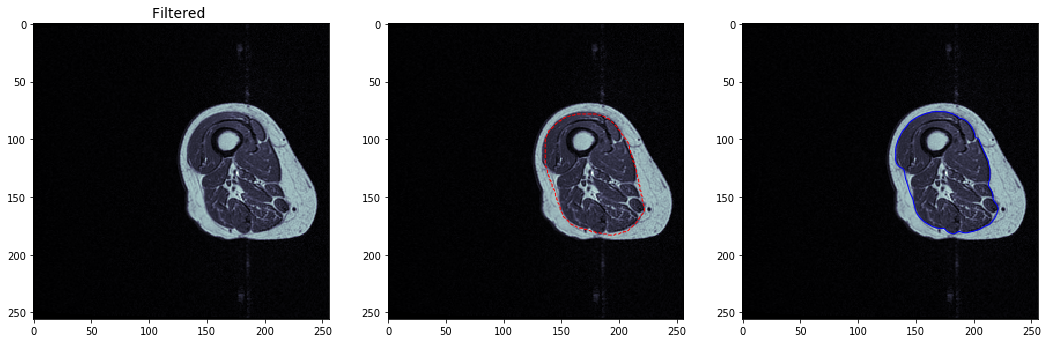

In [30]:
def snakes(image,hull):
    snake_coord=[]
    snake_coord= active_contour(image, hull_contour_coords2,alpha=0.1, beta=2,gamma=5, w_edge=10)#convergence=30, w_line=-200)#,, w_edge=500,gamma=3, )

    return snake_coord

snake_coord=snakes(thigh_c,hull_contour_coords2) #apply snakes fem onto bilateral filtered coronal im


fig, axs = plt.subplots(1, 3, figsize=(18,15))   
axs[0].set_title(f"Filtered ", fontsize=14)
axs[0].imshow(thigh_c, cmap='bone')

axs[1].imshow(thigh_c, cmap='bone')
axs[1].plot(hull_contour_coords2[:, 0], hull_contour_coords2[:, 1], '--r', lw=1)

axs[2].imshow(thigh_c, cmap='bone')
axs[2].plot(snake_coord[:, 0], snake_coord[:, 1], '-b', lw=1);


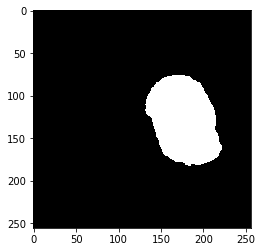

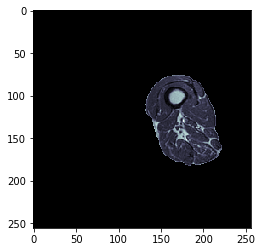

In [36]:
def get_snakemask(snake_coord):
    vol=[]

    for i2 in range(len(snake_coord)):
        vol.append([])
        vol[i2].append(snake_coord[i2])

    vol=np.rint(vol).astype(int) #why need rint??

    drawsnake= np.zeros([thigh_c.shape[0], thigh_c.shape[1]], dtype='uint8') 


    #polylines function connects the dots to make it one smooth contour

    cv2.polylines(drawsnake, [vol], isClosed=True, color = (1, 0, 0) , thickness=1) 

    snakemask=drawsnake.copy()

    h, w = thigh_c.shape[:2] #why slice here??

    mask = np.zeros((h+2, w+2), np.uint8)
    (x,y),radius = cv2.minEnclosingCircle(vol) #(x, y) coordinates of the centre of the "circle"
    cv2.floodFill(snakemask, mask, (round(x),round(y)), 255)

    ret, snakemask = cv2.threshold(snakemask,0,1,cv2.THRESH_BINARY)
    return snakemask

snakemask=get_snakemask(snake_coord)
show(snakemask)

final=snakemask*thigh_c
show(final)